# Credit Default Prediction - Complete Pipeline

## 1. Introduction
**What:** This notebook presents a complete machine learning pipeline to predict credit default risk (Good vs. Bad credit).
**Why:** Credit default prediction is crucial for financial institutions to minimize risk and make informed lending decisions.
**Goal:** To train and evaluate multiple machine learning models, including advanced Gradient Boosting techniques (XGBoost, LightGBM, CatBoost) and Interpretability-focused models (GAMs).
**Pipeline Steps:**
1.  **Data Loading & Cleaning:** Mapping cryptic codes to meaningful labels.
2.  **Exploratory Data Analysis (EDA):** Visualizing distributions and relationships.
3.  **Preprocessing:** Encoding and scaling.
4.  **Unsupervised Analysis:** PCA and Clustering.
5.  **Model Training:** Training a suite of models.
6.  **Advanced Evaluation:** K-Fold CV, Calibration, Cost Analysis, and Robustness Checks.


## 2. Setup and Imports
**What:** Importing necessary Python libraries.
**Why:** We need `pandas` for data, `sklearn` for modeling, `imblearn` for resampling, and `interpret` for GAMs.



In [106]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, cross_validate
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from interpret.glassbox import ExplainableBoostingClassifier
from sklearn.metrics import (accuracy_score, roc_auc_score, confusion_matrix, classification_report, 
                             f1_score, average_precision_score, brier_score_loss, precision_recall_curve)
from sklearn.calibration import CalibratedClassifierCV, CalibrationDisplay
from sklearn.frozen import FrozenEstimator
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
# Set visualization style
sns.set_style("whitegrid")


## 3. Data Loading
**What:** Loading the German Credit dataset.
**Details:** Defining column names manually as the dataset lacks a header.


In [107]:
# Define column names
columns = [
    "status", "duration", "credit_history", "purpose", "credit_amount",
    "savings", "employment_duration", "installment_rate", "personal_status_sex",
    "other_debtors", "residence_since", "property", "age", "other_installment_plans",
    "housing", "existing_credits", "job", "people_liable", "telephone", "foreign_worker",
    "credit_risk"
]

def load_data():
    filepath = "dataset.data"
    if not os.path.exists(filepath):
        print(f"Error: {filepath} not found.")
        return None
    df = pd.read_csv(filepath, sep=" ", names=columns, header=None)
    return df

df = load_data()
if df is not None:
    print("Dataset loaded successfully.")
    display(df.head())


Dataset loaded successfully.


,status,duration,credit_history,purpose,credit_amount,savings,employment_duration,installment_rate,personal_status_sex,other_debtors,...,property,age,other_installment_plans,housing,existing_credits,job,people_liable,telephone,foreign_worker,credit_risk
0,A11,6,A34,A43,1169,A65,A75,4,A93,A101,...,A121,67,A143,A152,2,A173,1,A192,A201,1
1,A12,48,A32,A43,5951,A61,A73,2,A92,A101,...,A121,22,A143,A152,1,A173,1,A191,A201,2
2,A14,12,A34,A46,2096,A61,A74,2,A93,A101,...,A121,49,A143,A152,1,A172,2,A191,A201,1
3,A11,42,A32,A42,7882,A61,A74,2,A93,A103,...,A122,45,A143,A153,1,A173,2,A191,A201,1
4,A11,24,A33,A40,4870,A61,A73,3,A93,A101,...,A124,53,A143,A153,2,A173,2,A191,A201,2


## 4. Data Cleaning and Mapping
**What:** Mapping cryptic codes to meaningful labels.
**Why:** To improve interpretability.


In [108]:
# Mapping dictionary based on dataset documentation
mappings = {
    "status": {"A11": "< 0 DM", "A12": "0 <= ... < 200 DM", "A13": ">= 200 DM", "A14": "no checking"},
    "credit_history": {"A30": "no credits/paid", "A31": "all paid at this bank", "A32": "existing paid", "A33": "delay", "A34": "critical/other"},
    "purpose": {"A40": "car (new)", "A41": "car (used)", "A42": "furniture/equipment", "A43": "radio/tv", "A44": "domestic appliances", "A45": "repairs", "A46": "education", "A47": "vacation", "A48": "retraining", "A49": "business", "A410": "others"},
    "savings": {"A61": "< 100 DM", "A62": "100 <= ... < 500 DM", "A63": "500 <= ... < 1000 DM", "A64": ">= 1000 DM", "A65": "unknown/none"},
    "employment_duration": {"A71": "unemployed", "A72": "< 1 year", "A73": "1 <= ... < 4 years", "A74": "4 <= ... < 7 years", "A75": ">= 7 years"},
    "personal_status_sex": {"A91": "male: divorced/separated", "A92": "female: div/dep/mar", "A93": "male: single", "A94": "male: mar/wid", "A95": "female: single"},
    "other_debtors": {"A101": "none", "A102": "co-applicant", "A103": "guarantor"},
    "property": {"A121": "real estate", "A122": "building society/life ins", "A123": "car/other", "A124": "unknown/none"},
    "other_installment_plans": {"A141": "bank", "A142": "stores", "A143": "none"},
    "housing": {"A151": "rent", "A152": "own", "A153": "for free"},
    "job": {"A171": "unemployed/unskilled non-res", "A172": "unskilled res", "A173": "skilled", "A174": "management/self-employed"},
    "telephone": {"A191": "none", "A192": "yes"},
    "foreign_worker": {"A201": "yes", "A202": "no"}
}

for col, mapping in mappings.items():
    if col in df.columns:
        df[col] = df[col].map(mapping).fillna(df[col])

print("Data cleaning complete.")
display(df.head())


Data cleaning complete.


,status,duration,credit_history,purpose,credit_amount,savings,employment_duration,installment_rate,personal_status_sex,other_debtors,...,property,age,other_installment_plans,housing,existing_credits,job,people_liable,telephone,foreign_worker,credit_risk
0,< 0 DM,6,critical/other,radio/tv,1169,unknown/none,>= 7 years,4,male: single,none,...,real estate,67,none,own,2,skilled,1,yes,yes,1
1,0 <= ... < 200 DM,48,existing paid,radio/tv,5951,< 100 DM,1 <= ... < 4 years,2,female: div/dep/mar,none,...,real estate,22,none,own,1,skilled,1,none,yes,2
2,no checking,12,critical/other,education,2096,< 100 DM,4 <= ... < 7 years,2,male: single,none,...,real estate,49,none,own,1,unskilled res,2,none,yes,1
3,< 0 DM,42,existing paid,furniture/equipment,7882,< 100 DM,4 <= ... < 7 years,2,male: single,guarantor,...,building society/life ins,45,none,for free,1,skilled,2,none,yes,1
4,< 0 DM,24,delay,car (new),4870,< 100 DM,1 <= ... < 4 years,3,male: single,none,...,unknown/none,53,none,for free,2,skilled,2,none,yes,2


## 5. Exploratory Data Analysis (EDA)
**What:** Analyzing the dataset to understand its structure, distributions, and relationships.
**Why:** To identify patterns, outliers, and potential data quality issues before modeling.


### 5.1 Target Distribution


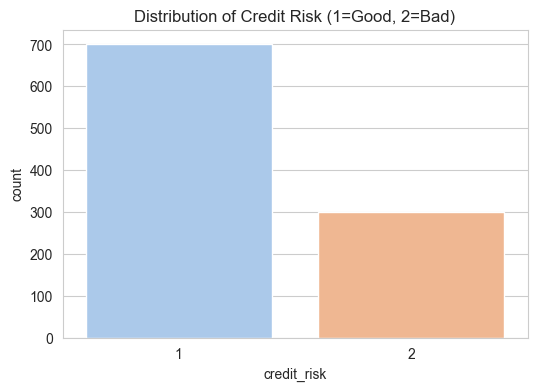

In [109]:
plt.figure(figsize=(6, 4))
sns.countplot(x='credit_risk', data=df, hue='credit_risk', legend=False, palette='pastel')
plt.title('Distribution of Credit Risk (1=Good, 2=Bad)')
plt.show()


### 5.2 Numerical Features Analysis


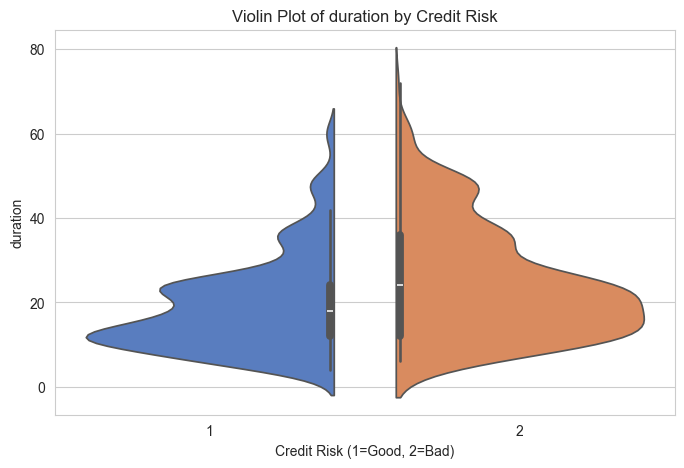

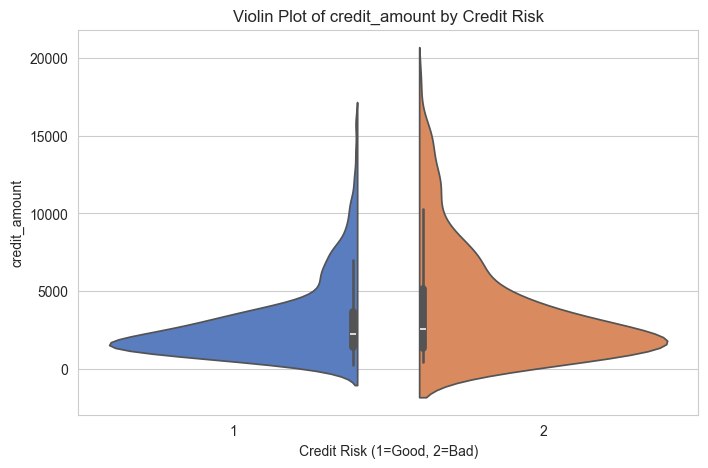

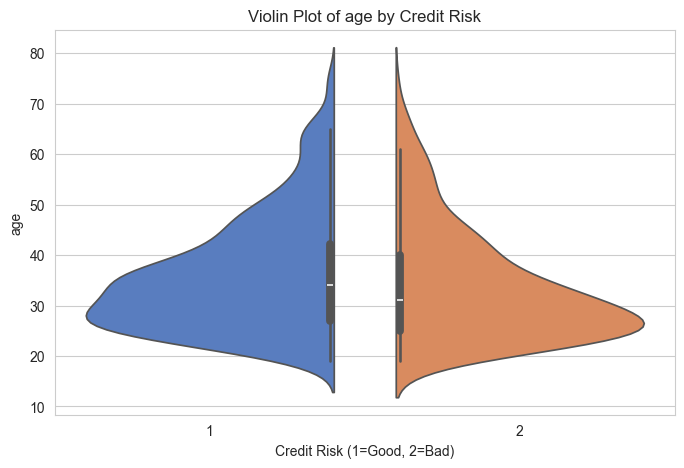

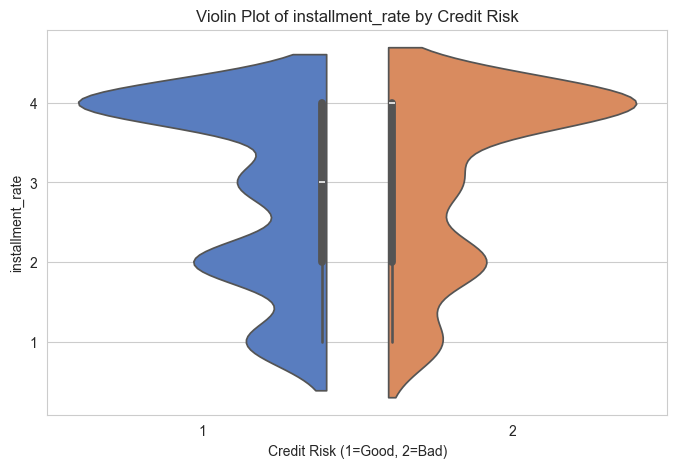

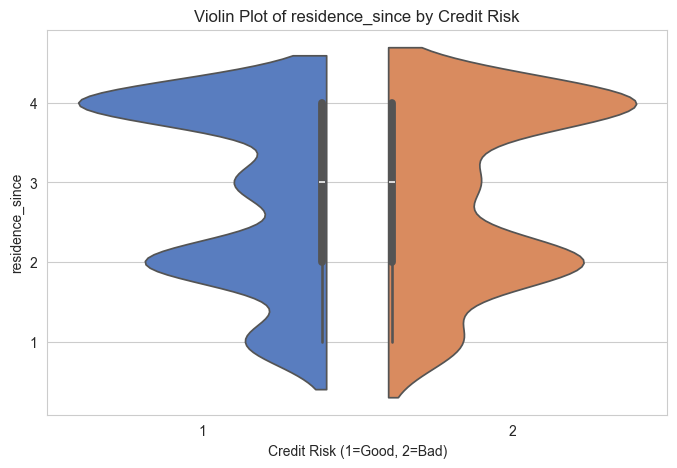

In [110]:
def plot_numerical_by_target(df):
    numerical_cols = ["duration", "credit_amount", "age", "installment_rate", "residence_since"]
    
    for col in numerical_cols:
        plt.figure(figsize=(8, 5))
        sns.violinplot(x='credit_risk', y=col, data=df, hue='credit_risk', legend=False, palette="muted", split=True)
        plt.title(f'Violin Plot of {col} by Credit Risk')
        plt.xlabel('Credit Risk (1=Good, 2=Bad)')
        plt.show()

plot_numerical_by_target(df)


### 5.3 Categorical Features Analysis


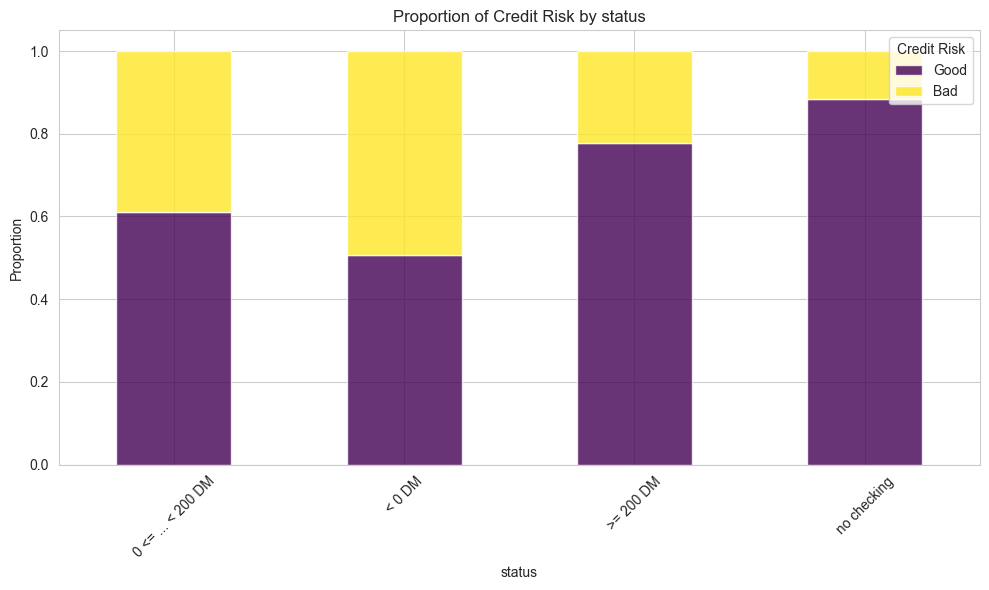

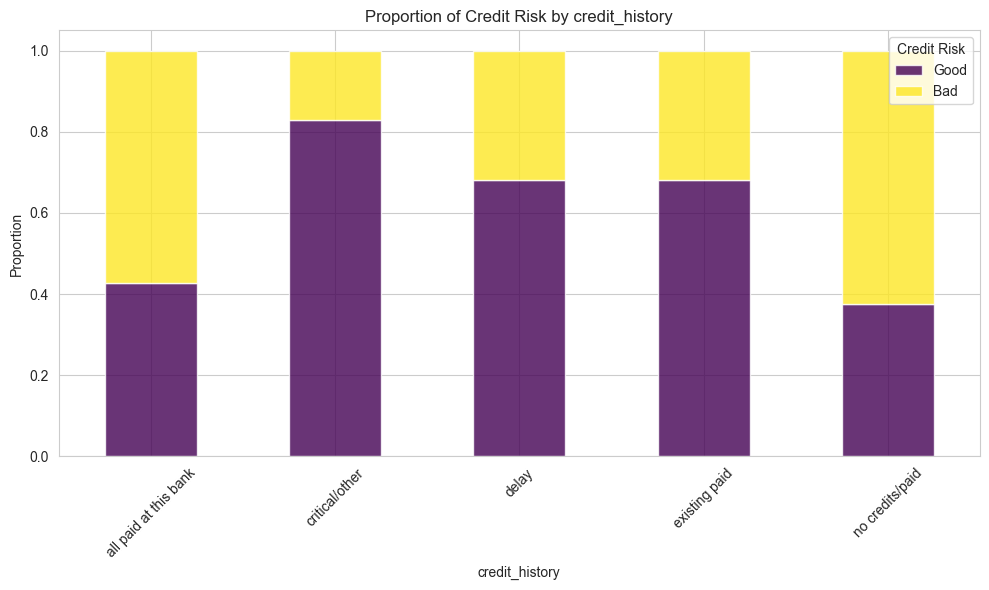

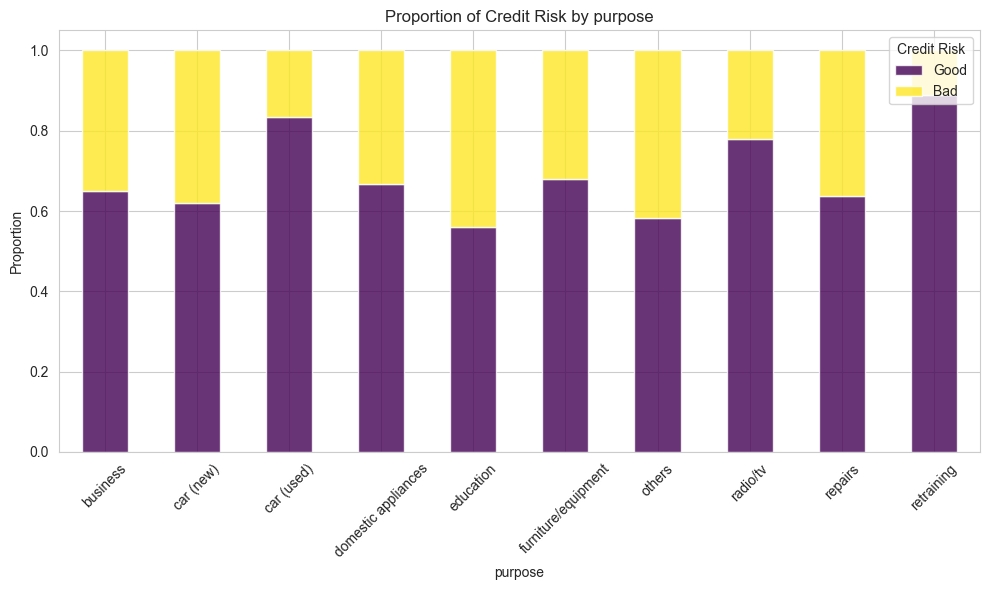

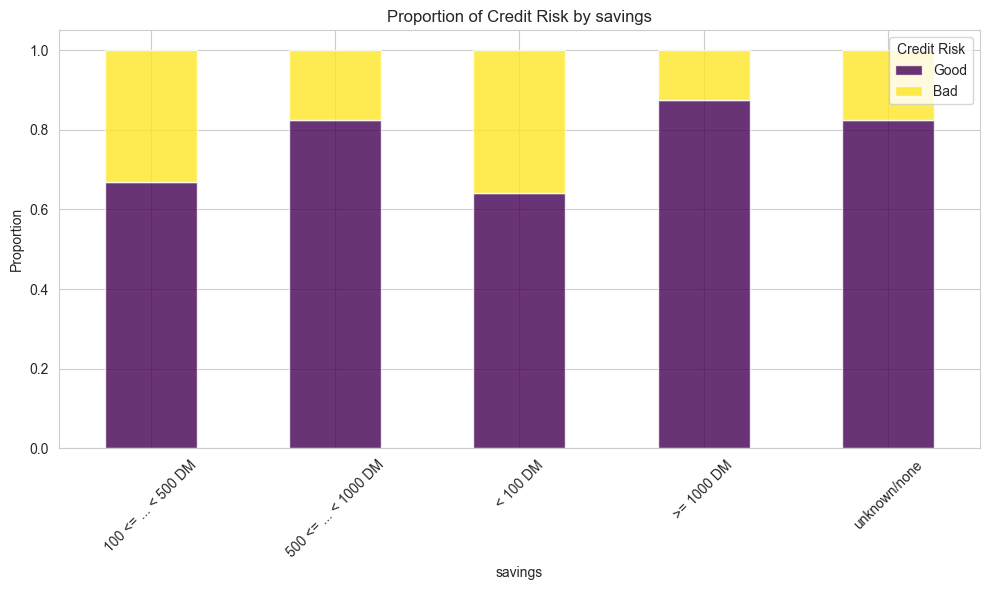

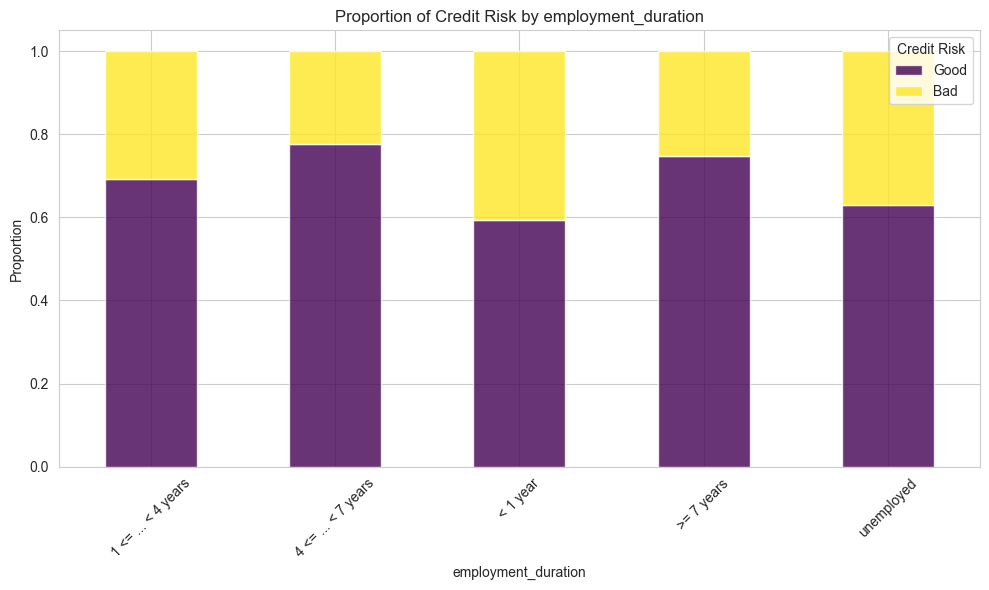

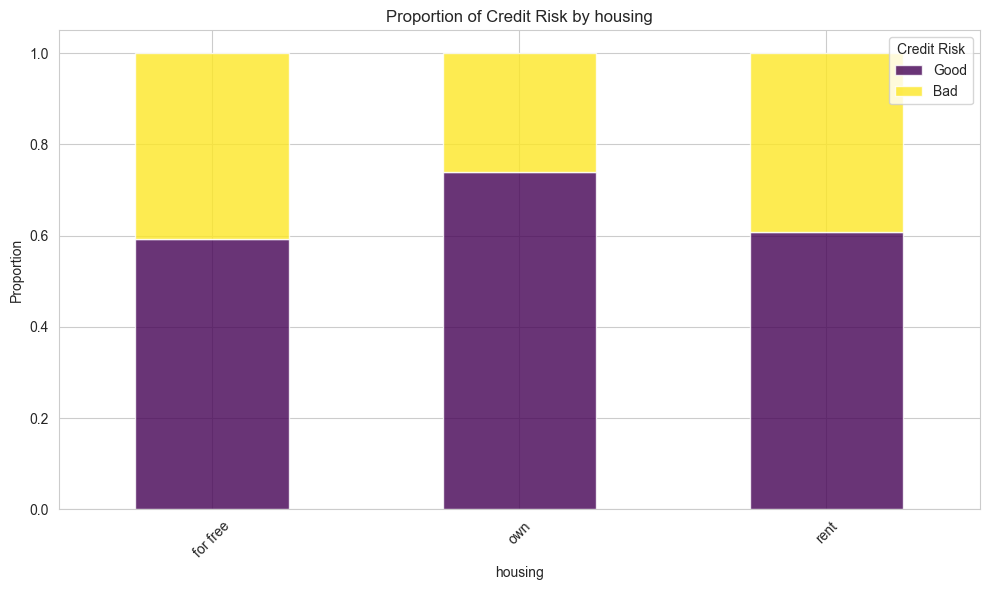

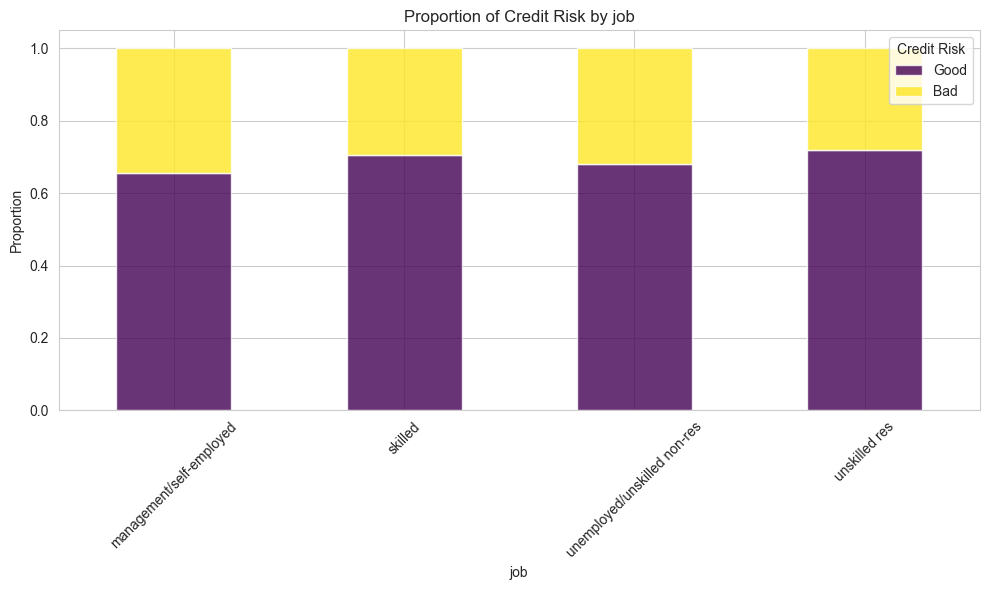

In [111]:
def plot_categorical_by_target(df):
    categorical_cols = ["status", "credit_history", "purpose", "savings", "employment_duration", "housing", "job"]
    
    for col in categorical_cols:
        crosstab = pd.crosstab(df[col], df['credit_risk'], normalize='index')
        crosstab.plot(kind='bar', stacked=True, figsize=(10, 6), colormap='viridis', alpha=0.8)
        plt.title(f'Proportion of Credit Risk by {col}')
        plt.xlabel(col)
        plt.ylabel('Proportion')
        plt.legend(title='Credit Risk', loc='upper right', labels=['Good', 'Bad'])
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

plot_categorical_by_target(df)


### 5.4 Correlation Analysis


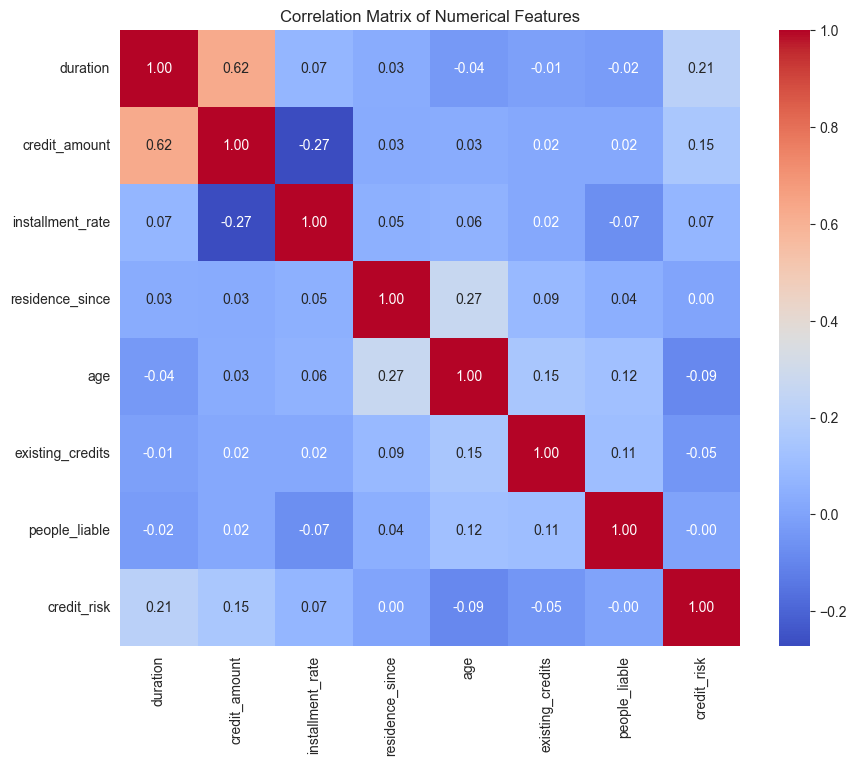

In [112]:
numerical_df = df.select_dtypes(include=['int64', 'float64'])
plt.figure(figsize=(10, 8))
corr = numerical_df.corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Numerical Features')
plt.show()


## 6. Data Preprocessing
**What:** Preparing data for modeling.
**Steps:**
1.  **Target Encoding:** 1 (Good) -> 0, 2 (Bad) -> 1.
2.  **Train/Test Split:** 80/20 split.
3.  **Preprocessing:** Scaling numericals, One-Hot Encoding categoricals.


In [113]:
# Encode target: 1 (Good) -> 0, 2 (Bad) -> 1
df['target'] = df['credit_risk'].apply(lambda x: 0 if x == 1 else 1)

X = df.drop(['credit_risk', 'target'], axis=1)
y = df['target']

categorical_cols = X.select_dtypes(include=['object']).columns
numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_cols)
    ])

X_train_preprocessed = preprocessor.fit_transform(X_train)
X_test_preprocessed = preprocessor.transform(X_test)
print(f"Training Set: {X_train.shape[0]}, Test Set: {X_test.shape[0]}")


Training Set: 800, Test Set: 200


## 7. Unsupervised Analysis
**What:** PCA and Clustering to explore data structure.



Performing PCA Analysis...
Explained Variance Ratio (First 2 components): [0.13429508 0.11385863]


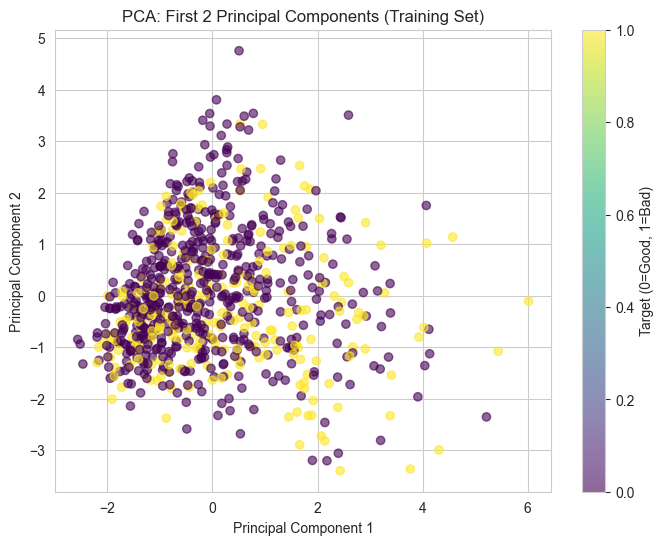

In [114]:
print("\nPerforming PCA Analysis...")
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train_preprocessed)

explained_variance = pca.explained_variance_ratio_
print(f"Explained Variance Ratio (First 2 components): {explained_variance}")

plt.figure(figsize=(8, 6))
scatter = plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1], c=y_train, cmap='viridis', alpha=0.6)
plt.title('PCA: First 2 Principal Components (Training Set)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar(scatter, label='Target (0=Good, 1=Bad)')
plt.show()



Performing Clustering Analysis...
Calculating Elbow Method...


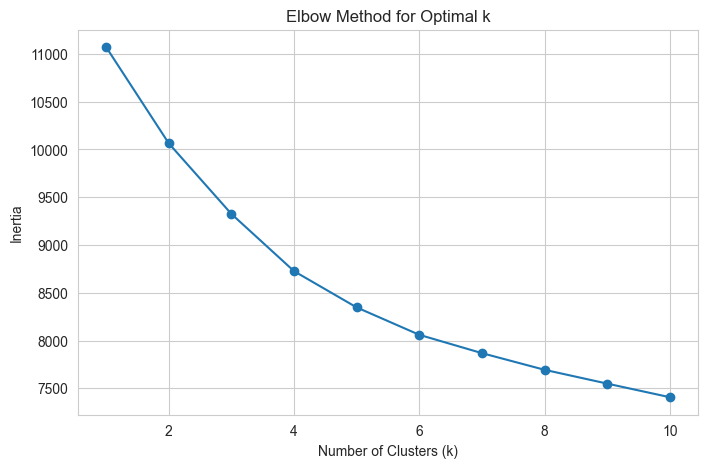

Running K-Means with k=3...

K-Means (k=3) Cluster Distribution vs Target:
Cluster  Target
0        0         0.855072
         1         0.144928
1        1         0.522727
         0         0.477273
2        0         0.689655
         1         0.310345
Name: proportion, dtype: float64


In [115]:
print("\nPerforming Clustering Analysis...")

# Elbow Method
print("Calculating Elbow Method...")
inertia = []
K_range = range(1, 11)
for k in K_range:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    km.fit(X_train_preprocessed)
    inertia.append(km.inertia_)

plt.figure(figsize=(8, 5))
plt.plot(K_range, inertia, marker='o')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.show()

# K-Means with k=3
print("Running K-Means with k=3...")
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
kmeans.fit(X_train_preprocessed)
test_clusters_km = kmeans.predict(X_test_preprocessed)

# GMM
gmm = GaussianMixture(n_components=2, random_state=42)
gmm.fit(X_train_preprocessed)
test_clusters_gmm = gmm.predict(X_test_preprocessed)

def get_cluster_accuracy(y_true, y_cluster):
    # Simple purity check for binary target vs clusters (mapping required for >2 clusters is complex, 
    # so we just print distribution for k=3)
    df_res = pd.DataFrame({'Cluster': y_cluster, 'Target': y_true})
    print(df_res.groupby('Cluster')['Target'].value_counts(normalize=True))

print("\nK-Means (k=3) Cluster Distribution vs Target:")
get_cluster_accuracy(y_test, test_clusters_km)


## 8. Advanced Evaluation Setup
**What:** Defining the models and the evaluation framework.
**Key Components:**
*   **K-Fold Cross-Validation:** We use 10-fold stratified CV to get a stable estimate of model performance.
*   **Probability Calibration:** We apply Isotonic Regression to calibrate probabilities.
*   **Metrics:** We track Accuracy, ROC AUC, PR AUC, and Brier Score.
*   **Cost Analysis:** We define a custom cost function.



In [116]:
# Prepare constraints for XGBoost
duration_idx = list(numerical_cols).index('duration')
amount_idx = list(numerical_cols).index('credit_amount')
n_features = X_train_preprocessed.shape[1]
monotone_constraints = [0] * n_features
monotone_constraints[duration_idx] = 1
monotone_constraints[amount_idx] = 1
monotone_constraints = tuple(monotone_constraints)

# Define Base Models
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42),
    "XGBoost": XGBClassifier(eval_metric='logloss', random_state=42),
    "LightGBM": LGBMClassifier(random_state=42, verbose=-1),
    "CatBoost": CatBoostClassifier(verbose=0, random_state=42),
    "GAM (EBM)": ExplainableBoostingClassifier(random_state=42),
    "XGBoost (Constrained)": XGBClassifier(eval_metric='logloss', random_state=42, monotone_constraints=monotone_constraints)
}

# Cost Matrix
# Cost(FN) = 5 (Classifying Bad as Good)
# Cost(FP) = 1 (Classifying Good as Bad)
COST_FN = 5
COST_FP = 1

def calculate_cost(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    # cm structure: [[TN, FP], [FN, TP]]
    TN, FP, FN, TP = cm.ravel()
    return (FN * COST_FN) + (FP * COST_FP)



## 9. Calibration Optimization
**What:** Analyzing and improving probability calibration.
**Experiments:**
1.  **Method Comparison:** Platt Scaling (Sigmoid) vs. Isotonic Regression.
2.  **Binning Effect:** How the number of bins affects the "jaggedness" of the curve.
3.  **Regularization:** Using regularized models to improve native calibration.


### 9.1 Sigmoid vs. Isotonic Calibration
**Goal:** Compare parametric (Sigmoid) vs. non-parametric (Isotonic) calibration.
**Insight:** Sigmoid is safer for small datasets as it prevents overfitting to noise (jaggedness). Isotonic is more flexible but can overfit.


Experiment 1: Sigmoid vs. Isotonic Calibration


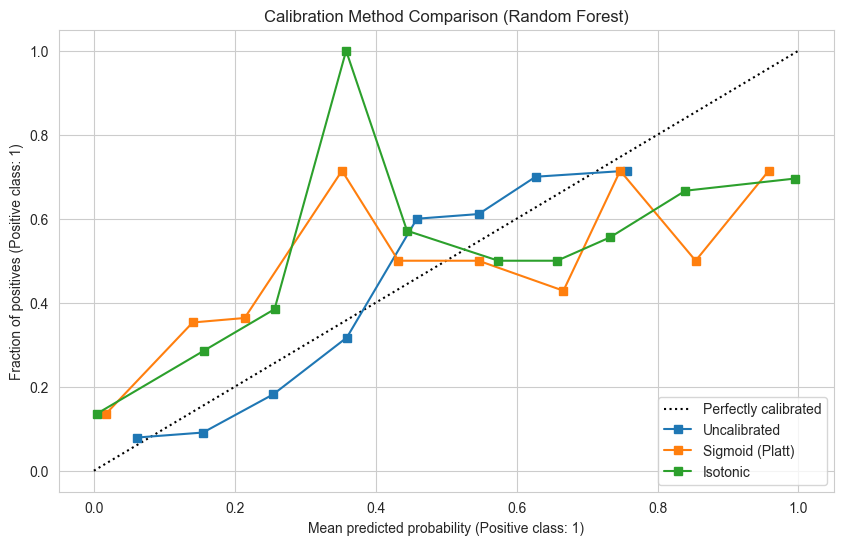

In [117]:
print("Experiment 1: Sigmoid vs. Isotonic Calibration")
from sklearn.calibration import calibration_curve

# Train a simple model (Random Forest)
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train_preprocessed, y_train)
prob_uncalibrated = rf.predict_proba(X_test_preprocessed)[:, 1]

# Calibrate
cal_sigmoid = CalibratedClassifierCV(FrozenEstimator(rf), method='sigmoid')
cal_sigmoid.fit(X_train_preprocessed, y_train)
prob_sigmoid = cal_sigmoid.predict_proba(X_test_preprocessed)[:, 1]

cal_isotonic = CalibratedClassifierCV(FrozenEstimator(rf), method='isotonic')
cal_isotonic.fit(X_train_preprocessed, y_train)
prob_isotonic = cal_isotonic.predict_proba(X_test_preprocessed)[:, 1]

# Plot
plt.figure(figsize=(10, 6))
CalibrationDisplay.from_predictions(y_test, prob_uncalibrated, n_bins=10, name='Uncalibrated', ax=plt.gca())
CalibrationDisplay.from_predictions(y_test, prob_sigmoid, n_bins=10, name='Sigmoid (Platt)', ax=plt.gca())
CalibrationDisplay.from_predictions(y_test, prob_isotonic, n_bins=10, name='Isotonic', ax=plt.gca())
plt.title('Calibration Method Comparison (Random Forest)')
plt.show()


### 9.2 Binning Effect on Visualization
**Goal:** Demonstrate how the number of bins affects the perceived "jaggedness".
**Insight:** Fewer bins smooth out the noise from small sample sizes in specific probability ranges.


Experiment 2: Binning Effect (CatBoost)


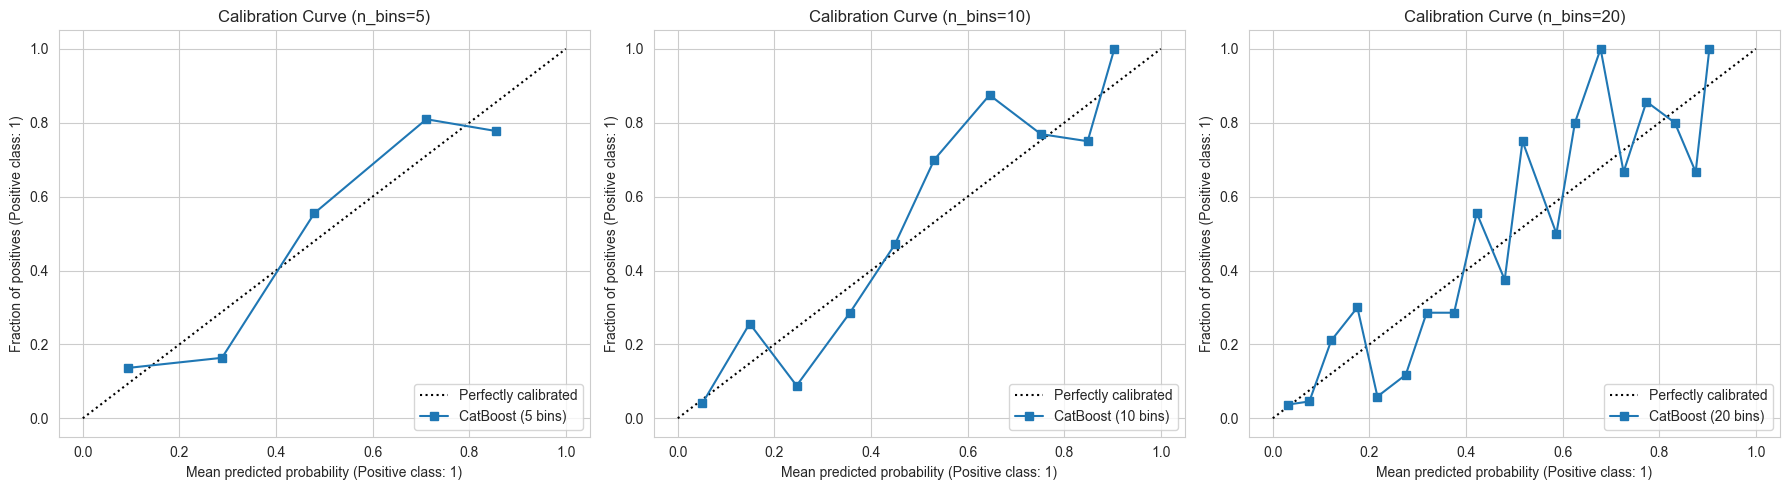

In [118]:
print("Experiment 2: Binning Effect (CatBoost)")
cat = CatBoostClassifier(verbose=0, random_state=42)
cat.fit(X_train_preprocessed, y_train)
prob_cat = cat.predict_proba(X_test_preprocessed)[:, 1]

fig, axes = plt.subplots(1, 3, figsize=(18, 5))
bins_list = [5, 10, 20]

for i, bins in enumerate(bins_list):
    CalibrationDisplay.from_predictions(y_test, prob_cat, n_bins=bins, name=f'CatBoost ({bins} bins)', ax=axes[i])
    axes[i].set_title(f'Calibration Curve (n_bins={bins})')

plt.tight_layout()
plt.show()


### 9.3 Regularization for Better Calibration
**Goal:** Improve native model calibration by reducing overfitting.
**Action:** Increase `min_child_weight` and reduce `learning_rate` for XGBoost.


Experiment 3: Regularization Effect (XGBoost)


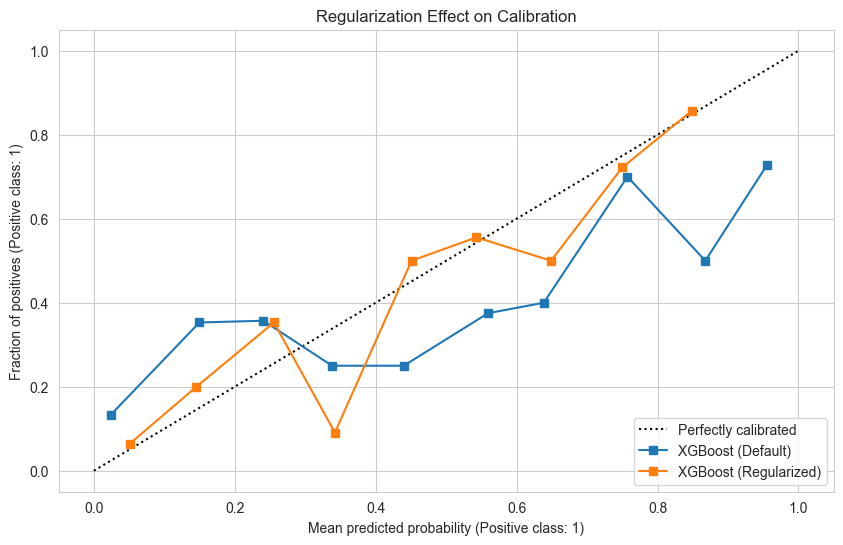

In [119]:
print("Experiment 3: Regularization Effect (XGBoost)")

# Default XGBoost
xgb_default = XGBClassifier(eval_metric='logloss', random_state=42)
xgb_default.fit(X_train_preprocessed, y_train)
prob_default = xgb_default.predict_proba(X_test_preprocessed)[:, 1]

# Regularized XGBoost
xgb_reg = XGBClassifier(
    eval_metric='logloss', 
    random_state=42,
    learning_rate=0.05,       # Slower learning
    n_estimators=200,         # More trees
    max_depth=3,              # Shallower trees
    min_child_weight=5,       # Higher leaf mass (prevents isolating outliers)
    subsample=0.8             # Row sampling
)
xgb_reg.fit(X_train_preprocessed, y_train)
prob_reg = xgb_reg.predict_proba(X_test_preprocessed)[:, 1]

plt.figure(figsize=(10, 6))
CalibrationDisplay.from_predictions(y_test, prob_default, n_bins=10, name='XGBoost (Default)', ax=plt.gca())
CalibrationDisplay.from_predictions(y_test, prob_reg, n_bins=10, name='XGBoost (Regularized)', ax=plt.gca())
plt.title('Regularization Effect on Calibration')
plt.show()


## 10. Final Model Evaluation, Calibration, and Evaluation
**What:** Training models, calibrating them, and evaluating on the test set.
**Why Calibration?** Many models (like Random Forest or Naive Bayes) do not output true probabilities. Calibration (Isotonic/Platt) adjusts the outputs so that a predicted probability of 0.8 actually means 80% of such cases are positive.
**Why PR-AUC?** For imbalanced datasets, Precision-Recall AUC is often more informative than ROC AUC.
**Why Brier Score?** It measures the accuracy of probabilistic predictions (lower is better).

**Update:** Using **Regularized Models** and **Sigmoid Calibration** with **n_bins=5** for robust results.

Model                     | Acc    | ROC    | PR-AUC | Brier  | Cost  
---------------------------------------------------------------------------
Logistic Regression       | 0.7950 | 0.8058 | 0.6328 | 0.1548 | 141   


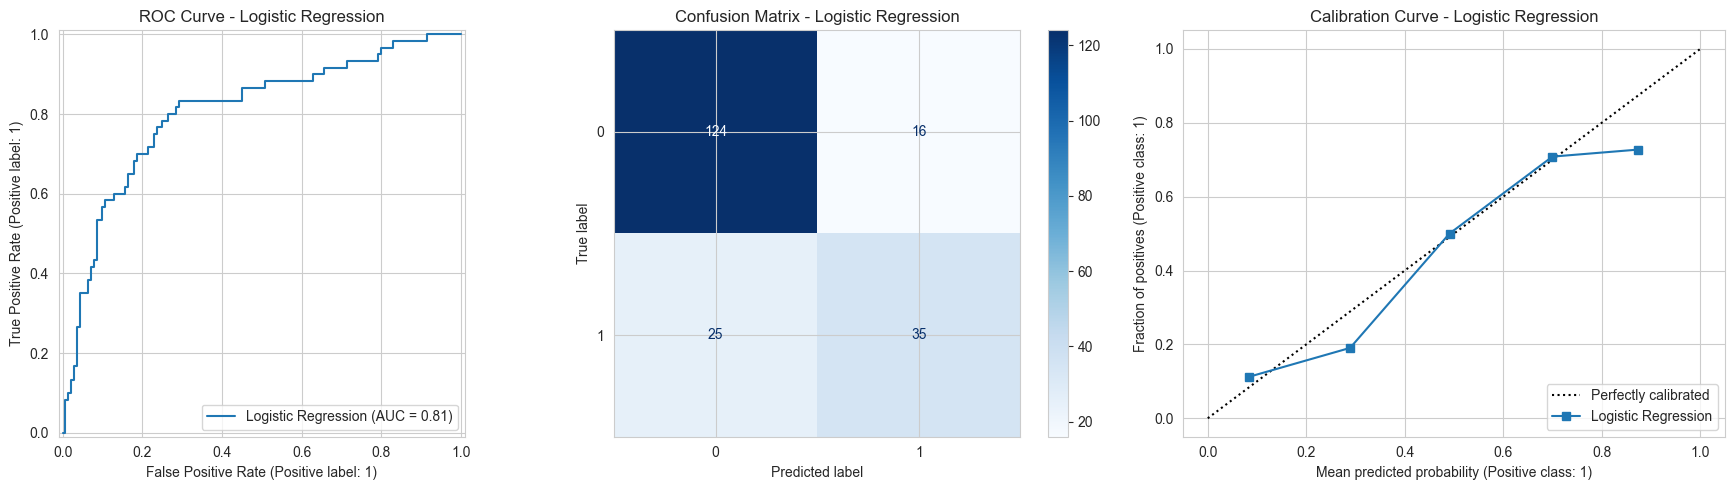

Random Forest             | 0.7500 | 0.7974 | 0.6411 | 0.1885 | 166   


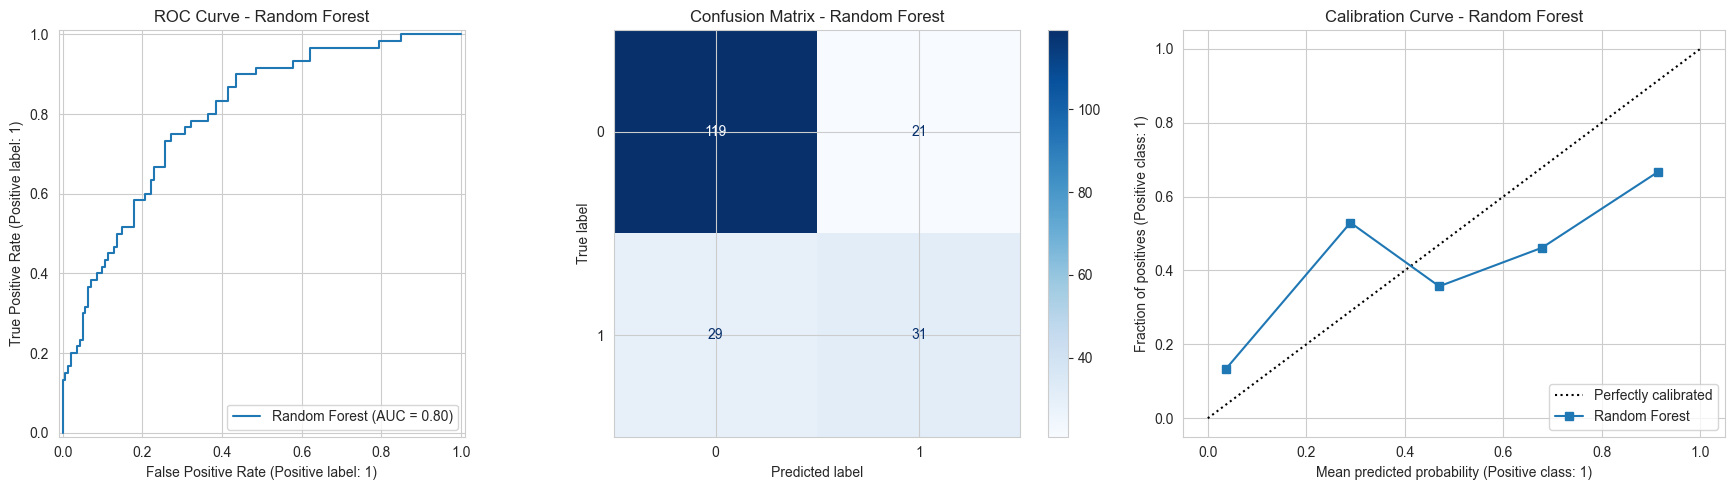

XGBoost                   | 0.7650 | 0.7829 | 0.6407 | 0.1765 | 151   


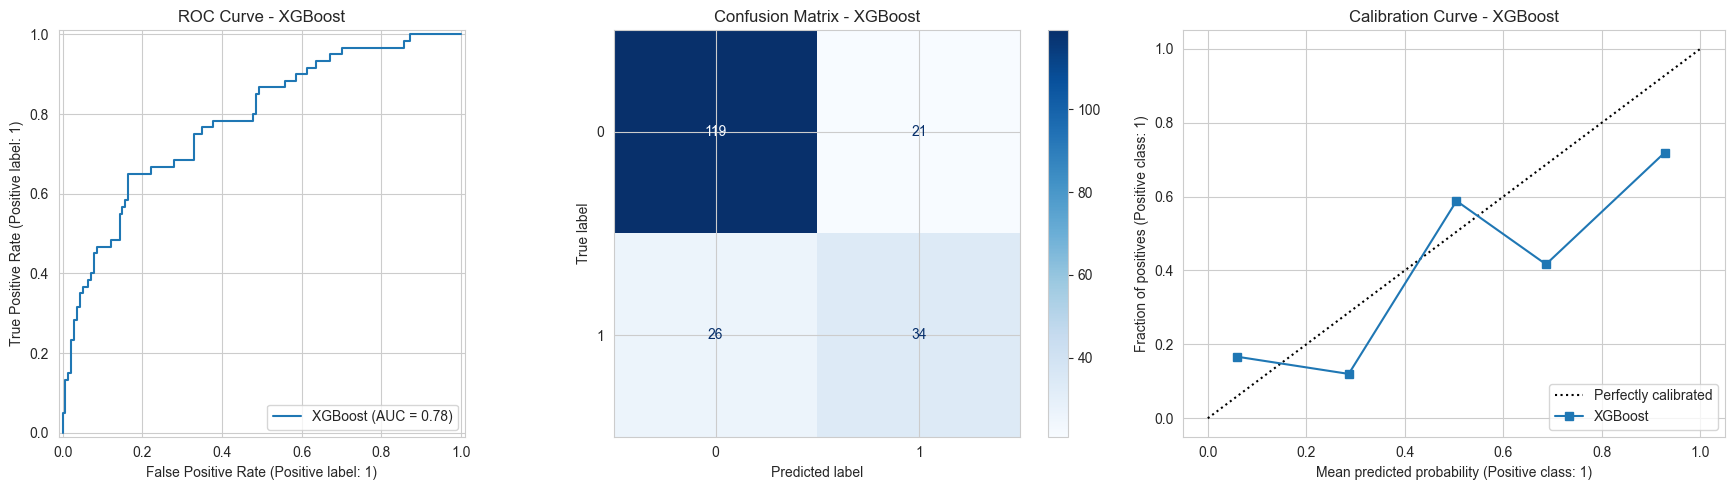

LightGBM                  | 0.7350 | 0.7715 | 0.6291 | 0.2276 | 177   


/Users/main/Coding/DataScience-ML-FinalProject/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/main/Coding/DataScience-ML-FinalProject/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/main/Coding/DataScience-ML-FinalProject/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/main/Coding/DataScience-ML-FinalProject/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/main/Coding/DataScience-ML-FinalProject/.venv/lib/python3.13/site

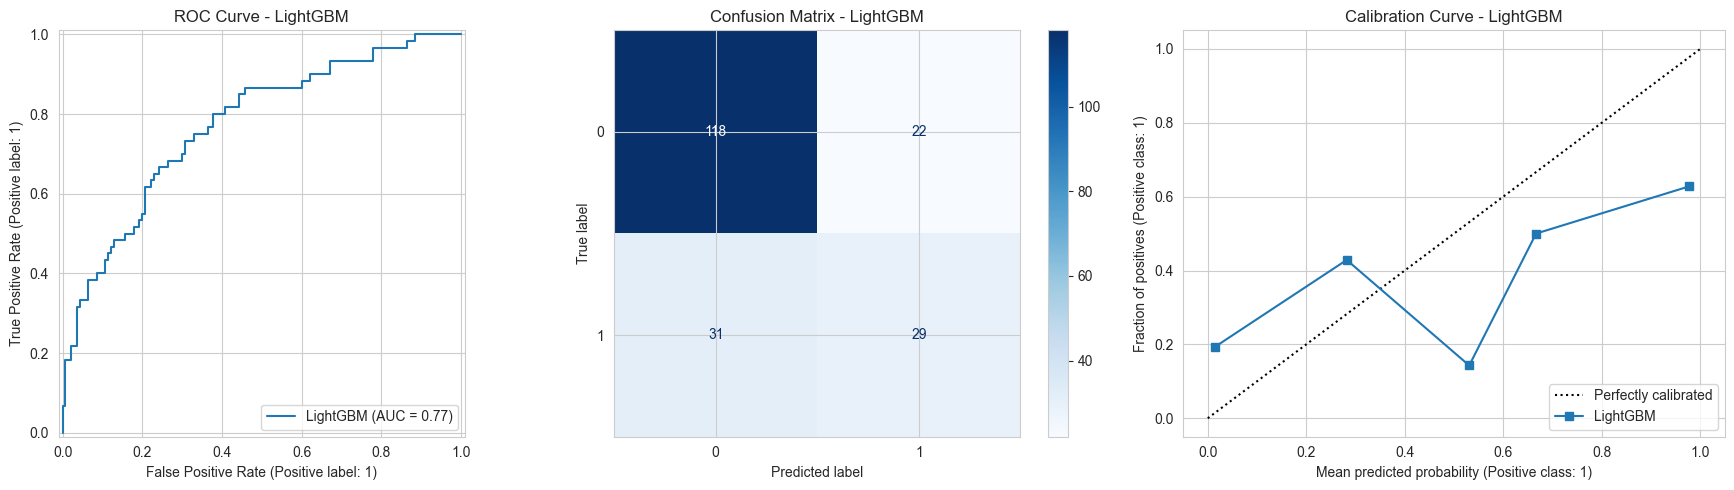

CatBoost                  | 0.8000 | 0.8082 | 0.6893 | 0.1679 | 132   


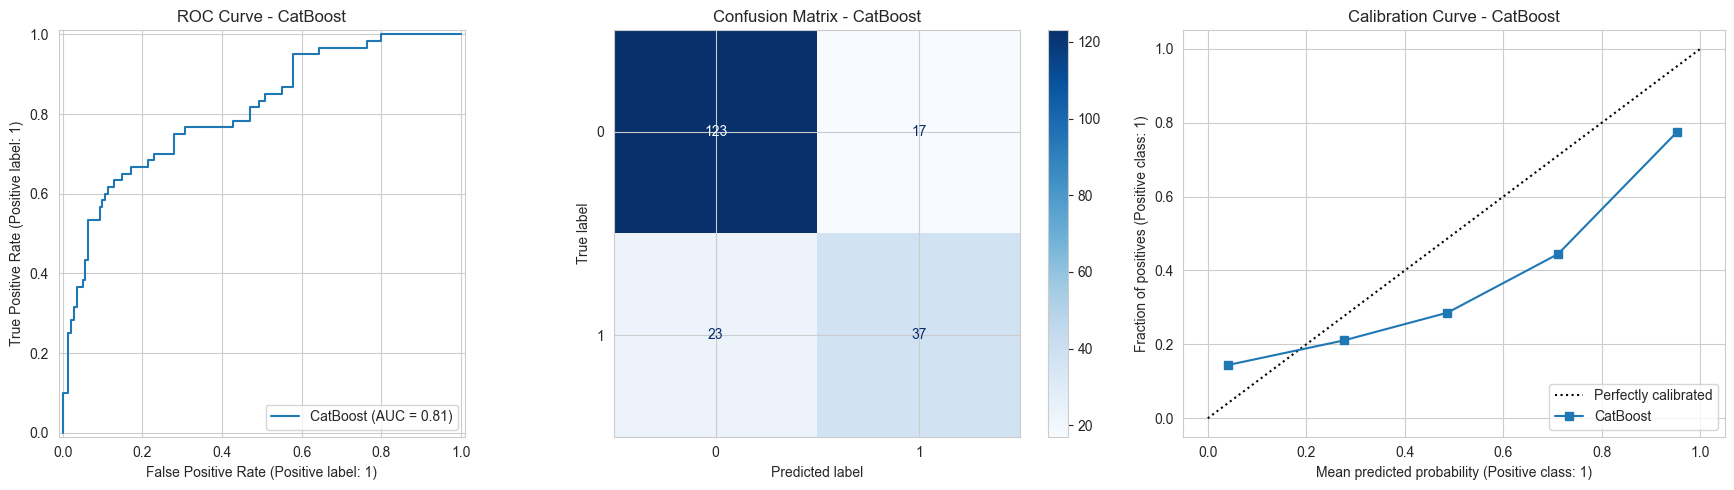

GAM (EBM)                 | 0.7700 | 0.7989 | 0.6226 | 0.1578 | 170   


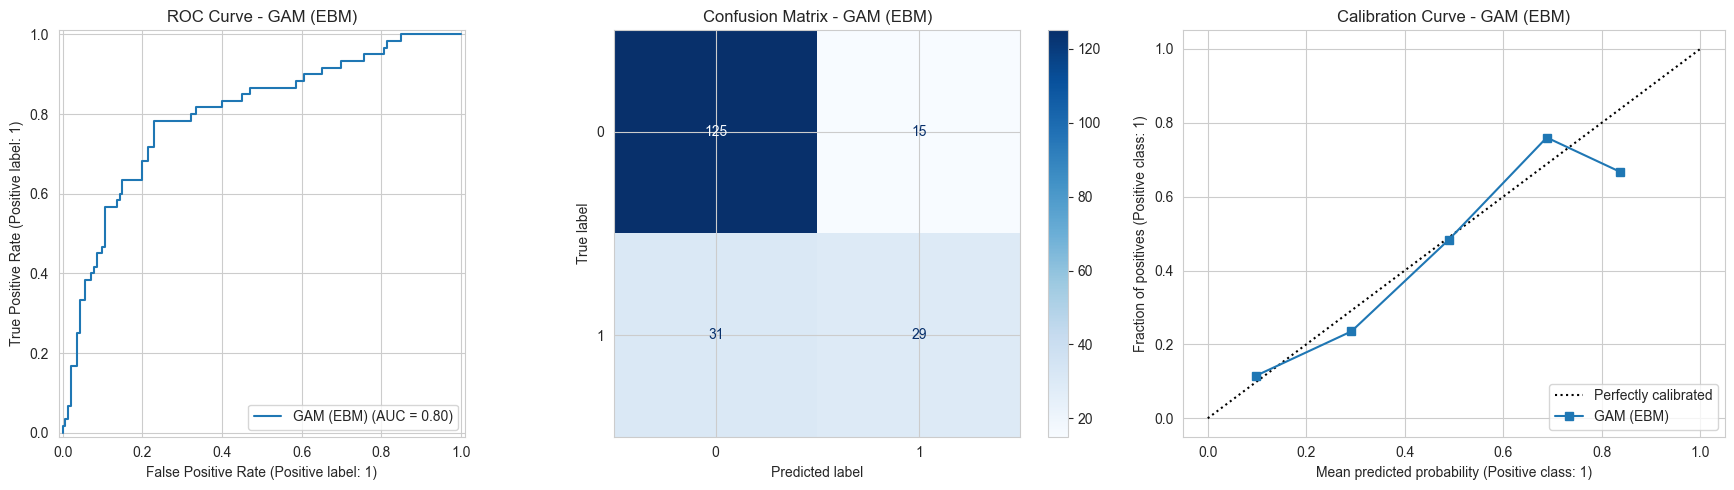


Performance Summary Table (Sorted by Cost):


,Model,Accuracy,ROC AUC,PR AUC,Brier Score,Cost
4,CatBoost,0.800,0.808214,0.689324,0.167934,132
0,Logistic Regression,0.795,0.805833,0.632799,0.154780,141
2,XGBoost,0.765,0.782857,0.640678,0.176463,151
1,Random Forest,0.750,0.797381,0.641119,0.188504,166
5,GAM (EBM),0.770,0.798929,0.622586,0.157839,170
3,LightGBM,0.735,0.771548,0.629082,0.227637,177


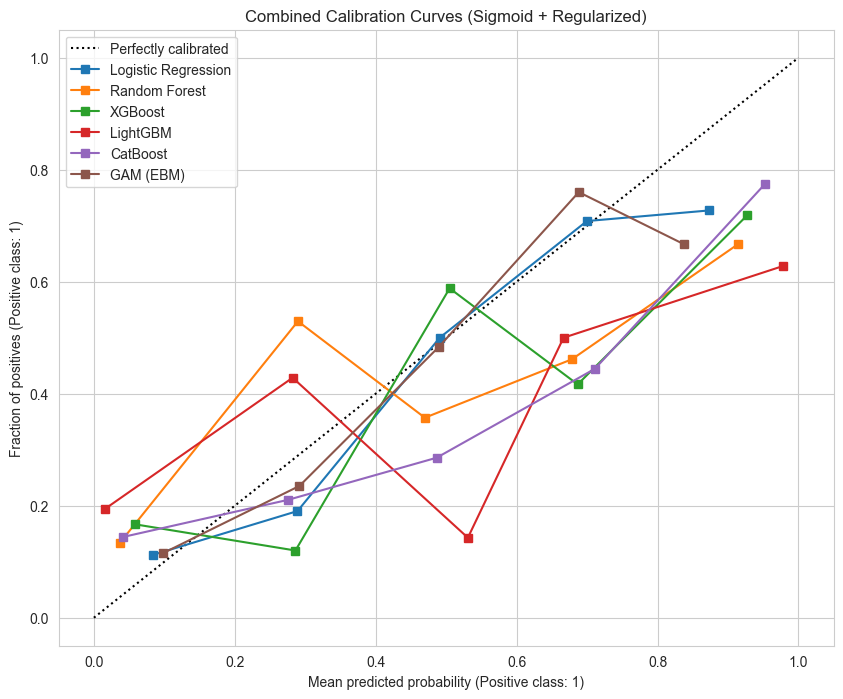


Predicted Probability Distributions:


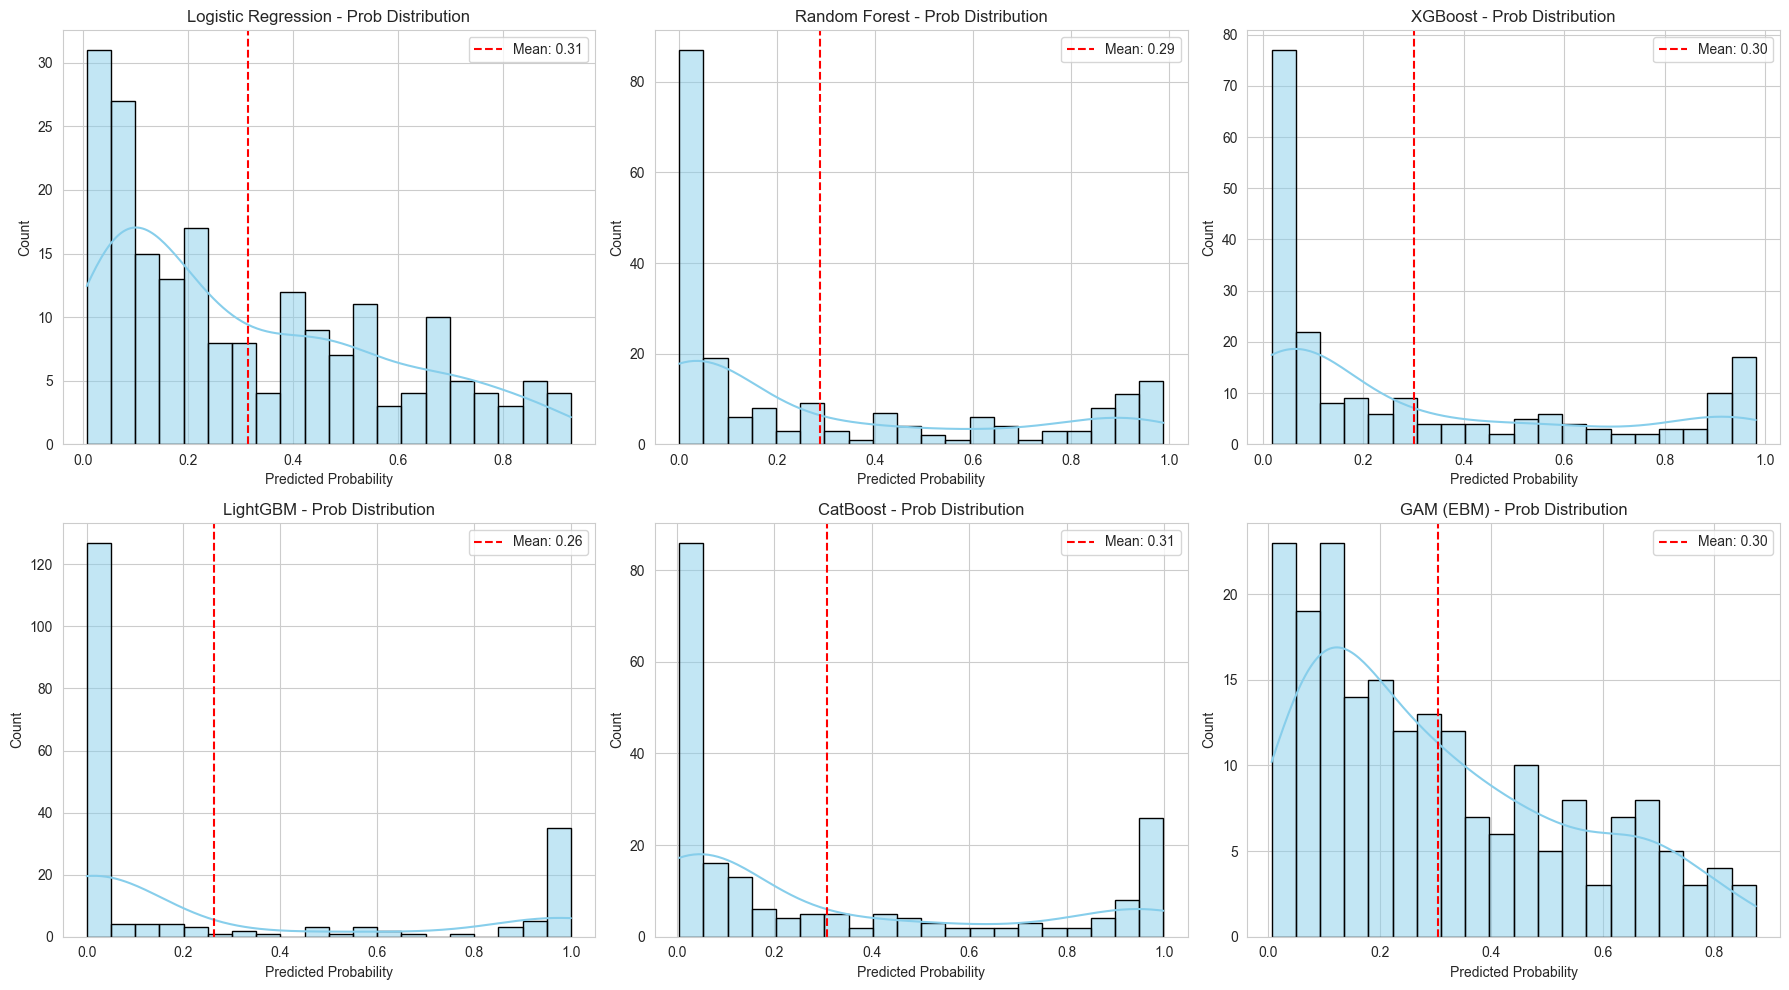

In [120]:
results = []
all_probs = {} # Store probabilities for combined plotting

print(f"{'Model':<25} | {'Acc':<6} | {'ROC':<6} | {'PR-AUC':<6} | {'Brier':<6} | {'Cost':<6}")
print("-" * 75)

# 10-Fold CV
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Define Regularized Models
models_optimized = {
    "Logistic Regression": LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=200, min_samples_leaf=5, class_weight='balanced', random_state=42),
    "XGBoost": XGBClassifier(eval_metric='logloss', learning_rate=0.05, n_estimators=200, max_depth=3, min_child_weight=5, subsample=0.8, random_state=42),
    "LightGBM": LGBMClassifier(learning_rate=0.05, n_estimators=200, num_leaves=20, min_child_samples=30, random_state=42, verbose=-1),
    "CatBoost": CatBoostClassifier(iterations=200, learning_rate=0.05, depth=4, l2_leaf_reg=5, verbose=0, random_state=42),
    "GAM (EBM)": ExplainableBoostingClassifier(random_state=42, interactions=0), # Simpler EBM
}

for name, model in models_optimized.items():
    # Handle EBM (raw data) vs others (preprocessed)
    if name == "GAM (EBM)":
        X_curr = X_train
        X_test_curr = X_test
    else:
        X_curr = X_train_preprocessed
        X_test_curr = X_test_preprocessed

    # 1. Train Base Model
    model.fit(X_curr, y_train)
    
    # 2. Calibrate Model (Sigmoid/Platt Scaling for safety)
    if name != "GAM (EBM)": 
        calibrated_model = CalibratedClassifierCV(FrozenEstimator(model), method='sigmoid')
        calibrated_model.fit(X_curr, y_train)
        final_model = calibrated_model
    else:
        final_model = model

    # 3. Predict
    y_prob = final_model.predict_proba(X_test_curr)[:, 1]
    y_pred = final_model.predict(X_test_curr)
    
    # Store for combined plots
    all_probs[name] = y_prob
    
    # 4. Calculate Metrics
    acc = accuracy_score(y_test, y_pred)
    roc = roc_auc_score(y_test, y_prob)
    pr_auc = average_precision_score(y_test, y_prob)
    brier = brier_score_loss(y_test, y_prob)
    cost = calculate_cost(y_test, y_pred)
    
    results.append({
        "Model": name,
        "Accuracy": acc,
        "ROC AUC": roc,
        "PR AUC": pr_auc,
        "Brier Score": brier,
        "Cost": cost
    })
    
    print(f"{name:<25} | {acc:.4f} | {roc:.4f} | {pr_auc:.4f} | {brier:.4f} | {cost:<6}")

    # 5. Visualizations (Individual)
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    
    # ROC Curve
    from sklearn.metrics import RocCurveDisplay
    RocCurveDisplay.from_predictions(y_test, y_prob, ax=axes[0], name=name)
    axes[0].set_title(f'ROC Curve - {name}')
    
    # Confusion Matrix
    from sklearn.metrics import ConfusionMatrixDisplay
    ConfusionMatrixDisplay.from_predictions(y_test, y_pred, ax=axes[1], cmap='Blues')
    axes[1].set_title(f'Confusion Matrix - {name}')
    
    # Calibration Curve (n_bins=5 for smoothing)
    CalibrationDisplay.from_predictions(y_test, y_prob, n_bins=5, name=name, ax=axes[2])
    axes[2].set_title(f'Calibration Curve - {name}')
    
    plt.tight_layout()
    plt.show()

# Performance Summary Table
results_df = pd.DataFrame(results)
results_df = results_df.sort_values(by="Cost", ascending=True)
print("\nPerformance Summary Table (Sorted by Cost):")
display(results_df)

# --- Combined Visualizations ---

# 1. Combined Calibration Curve (n_bins=5)
plt.figure(figsize=(10, 8))
for name, y_prob in all_probs.items():
    CalibrationDisplay.from_predictions(y_test, y_prob, n_bins=5, name=name, ax=plt.gca())
plt.title('Combined Calibration Curves (Sigmoid + Regularized)')
plt.legend(loc='best')
plt.show()

# 2. Mean Predicted Probability Charts (Distributions)
print("\nPredicted Probability Distributions:")
n_models = len(models_optimized)
cols = 3
rows = (n_models + cols - 1) // cols

fig, axes = plt.subplots(rows, cols, figsize=(18, 5 * rows))
axes = axes.flatten()

for i, (name, y_prob) in enumerate(all_probs.items()):
    mean_prob = np.mean(y_prob)
    sns.histplot(y_prob, bins=20, kde=True, ax=axes[i], color='skyblue', edgecolor='black')
    axes[i].axvline(mean_prob, color='red', linestyle='--', label=f'Mean: {mean_prob:.2f}')
    axes[i].set_title(f'{name} - Prob Distribution')
    axes[i].set_xlabel('Predicted Probability')
    axes[i].legend()

# Hide unused subplots
for j in range(i + 1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()


## 10. Cost-Sensitive Threshold Optimization
**What:** Finding the optimal probability threshold that minimizes the expected financial cost.
**Why:** The default threshold of 0.5 is rarely optimal when costs are asymmetric (Cost(FN) = 5 vs Cost(FP) = 1).
**Method:** We iterate through thresholds from 0 to 1, calculate the total cost for each, and find the minimum.


In [121]:
def plot_cost_curve(y_true, y_prob, model_name):
    thresholds = np.linspace(0, 1, 100)
    costs = []
    
    for t in thresholds:
        y_pred_t = (y_prob >= t).astype(int)
        costs.append(calculate_cost(y_true, y_pred_t))
        
    min_cost = min(costs)
    best_thresh = thresholds[np.argmin(costs)]
    
    plt.figure(figsize=(8, 5))
    plt.plot(thresholds, costs, label=f'{model_name} (Min Cost: {min_cost})')
    plt.axvline(best_thresh, color='r', linestyle='--', label=f'Optimal Thresh: {best_thresh:.2f}')
    plt.xlabel('Threshold')
    plt.ylabel('Total Cost')
    plt.title(f'Expected Cost by Threshold - {model_name}')
    plt.legend()
    plt.show()
    return min_cost, best_thresh

# Analyze Cost for the best performing model (e.g., CatBoost or EBM)
best_model_name = "CatBoost" # Example choice
if best_model_name in results:
    y_prob_best = results[best_model_name]["y_prob"]
    min_cost, best_thresh = plot_cost_curve(y_test, y_prob_best, best_model_name)
    print(f"Optimal Threshold for {best_model_name}: {best_thresh:.2f} with Min Cost: {min_cost}")


## 11. Robustness: Class Weighting vs. SMOTE
**What:** Comparing two techniques to handle class imbalance.
**1. Class Weighting:** Assigns higher penalties to misclassifying the minority class directly in the loss function.
**2. SMOTE (Synthetic Minority Over-sampling Technique):** Generates synthetic examples for the minority class to balance the dataset.
**Why:** To see which method yields better robustness and performance for this specific dataset.


In [122]:
print("Comparing Class Weighting vs. SMOTE for Random Forest...")

# 1. Class Weighting (Already done in base models)
rf_weighted = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42)
rf_weighted.fit(X_train_preprocessed, y_train)
y_pred_w = rf_weighted.predict(X_test_preprocessed)
cost_w = calculate_cost(y_test, y_pred_w)
print(f"Class Weighting Cost: {cost_w}")

# 2. SMOTE
smote_pipeline = ImbPipeline([
    ('smote', SMOTE(random_state=42)),
    ('rf', RandomForestClassifier(n_estimators=100, random_state=42)) # No class_weight here
])
smote_pipeline.fit(X_train_preprocessed, y_train)
y_pred_s = smote_pipeline.predict(X_test_preprocessed)
cost_s = calculate_cost(y_test, y_pred_s)
print(f"SMOTE Cost:           {cost_s}")

if cost_s < cost_w:
    print("Conclusion: SMOTE performed better.")
else:
    print("Conclusion: Class Weighting performed better.")


Comparing Class Weighting vs. SMOTE for Random Forest...
Class Weighting Cost: 180
SMOTE Cost:           173
Conclusion: SMOTE performed better.
